In [74]:
from dataset_loader import load_dataset
from utils import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

import os

In [75]:
# Specify the directory you want to read from
directory = os.path.join(os.path.dirname(os.getcwd()), 'ViT-L14')

# size = 252001
files_set = [
    '003.txt', '004.txt', '005.txt', 
    '006.txt', '007.txt', '048.txt',
    '049.txt', '055.txt', '056.txt',
    '057.txt'
]

In [76]:
image_names, dataset = load_dataset(directory, files_set)

Processing file: 003.txt
	Number of vectors: 5516
Processing file: 004.txt
	Number of vectors: 8386
Processing file: 005.txt
	Number of vectors: 13638
Processing file: 006.txt
	Number of vectors: 17044
Processing file: 007.txt
	Number of vectors: 15181
Processing file: 048.txt
	Number of vectors: 26687
Processing file: 049.txt
	Number of vectors: 44032
Processing file: 055.txt
	Number of vectors: 43070
Processing file: 056.txt
	Number of vectors: 39764
Processing file: 057.txt
	Number of vectors: 38683

Number of vectors in all files: 252001
Number of dimensions: 768


In [77]:
dataset = np.array(dataset)

In [78]:
num_of_queries = 80
num_nearest_neighbors = 50

dataset_tmp = np.array(dataset)

# create random queries 
queries = [random.choice(dataset_tmp) for _ in range(num_of_queries)]
range_queries = []

# transform k-nn query to range query
for query in queries:
    euc_dist = vectorized_euclidean_distances(query, dataset_tmp)
    euc_dist_sorted = np.argsort(euc_dist)[:num_nearest_neighbors]

    # Get the range value (r) for this query
    r = euc_dist[euc_dist_sorted[-1]]
    range_queries.append(r) 

In [79]:
# Starting value
start_value = 1.0
# Increment value
increment = 0.01
# Number of values
num_values = 28

# Generating the list of scaling factors and rounding each value to 3 decimal places
scaling_factors = [round(start_value + i * increment, 3) for i in range(num_values)]

scaling_factors

[1.0,
 1.01,
 1.02,
 1.03,
 1.04,
 1.05,
 1.06,
 1.07,
 1.08,
 1.09,
 1.1,
 1.11,
 1.12,
 1.13,
 1.14,
 1.15,
 1.16,
 1.17,
 1.18,
 1.19,
 1.2,
 1.21,
 1.22,
 1.23,
 1.24,
 1.25,
 1.26,
 1.27]

In [81]:
total_counts = []

for i, S_f in enumerate(scaling_factors):
    counts = []
    
    for idx, range_query in enumerate(range_queries):
        r = range_query
        
        r_e = r * S_f
        
        euc_dist = vectorized_euclidean_distances(queries[idx], dataset_tmp)
        # euc_dist_sorted = np.argsort(euc_dist)
        count_within_re = np.sum(euc_dist <= r_e)
        # print(f"count: {count_within_re}")
        
        counts.append(count_within_re)  # Append the count for this query
    
    total_counts.append(counts)

In [82]:
np.save("scaling_factors.npy", scaling_factors)
np.save("counts.npy", total_counts)

---

## If you want to only show previous results, start from here

In [83]:
scaling_factors = np.load("scaling_factors.npy").tolist()
total_counts = np.load("counts.npy").tolist()

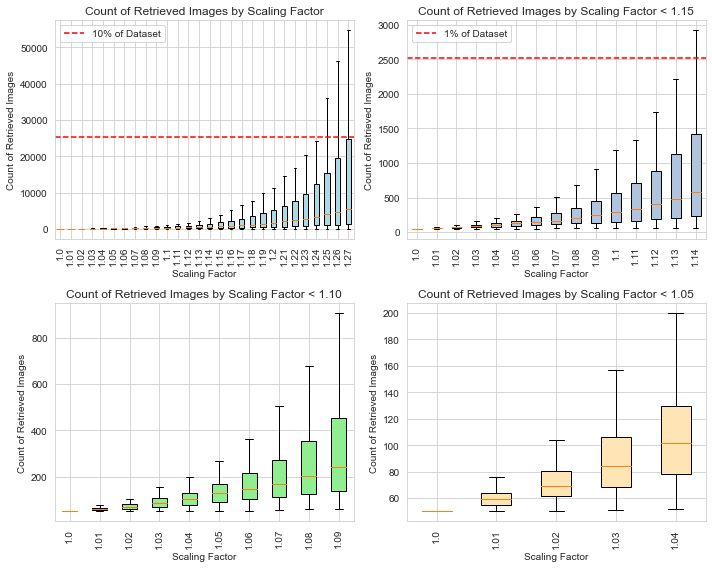

In [84]:
# Filter data for each scaling factor threshold (this will filter the total_counts)
def filter_data(scaling_factors, total_counts, threshold):
    filter_mask = scaling_factors < threshold
    return total_counts[filter_mask], scaling_factors[filter_mask]

# Define thresholds
ten_percent_value = len(dataset_tmp) * 0.1
one_percent_value = len(dataset_tmp) * 0.01

# # Filtered total counts based on scaling factor thresholds
total_counts_filtered_1_10, scaling_factors_filtered_1_10 = filter_data(np.array(scaling_factors), np.array(total_counts), 1.10)
total_counts_filtered_1_05, scaling_factors_filtered_1_05 = filter_data(np.array(scaling_factors), np.array(total_counts), 1.05)
total_counts_filtered_1_15, scaling_factors_filtered_1_15 = filter_data(np.array(scaling_factors), np.array(total_counts), 1.15)

# Set up 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# First plot: All scaling factors (Boxplot)
axes[0, 0].boxplot(total_counts, labels=scaling_factors, patch_artist=True, 
                   boxprops=dict(facecolor='lightblue', color='black'), showfliers=False)
axes[0, 0].axhline(y=ten_percent_value, color='r', linestyle='--', label='10% of Dataset')
axes[0, 0].set_xlabel('Scaling Factor')
axes[0, 0].set_ylabel('Count of Retrieved Images')
axes[0, 0].set_title('Count of Retrieved Images by Scaling Factor')
axes[0, 0].tick_params(axis='x', rotation=90, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
axes[0, 0].legend()
axes[0, 0].grid(True)

# Boxplot for Scaling Factor < 1.15
axes[0, 1].boxplot(total_counts_filtered_1_15.T, labels=scaling_factors_filtered_1_15, patch_artist=True,
                   boxprops=dict(facecolor='lightsteelblue', color='black'), showfliers=False)
axes[0, 1].axhline(y=one_percent_value, color='r', linestyle='--', label='1% of Dataset')
axes[0, 1].set_xlabel('Scaling Factor')
axes[0, 1].set_ylabel('Count of Retrieved Images')
axes[0, 1].set_title('Count of Retrieved Images by Scaling Factor < 1.15')
axes[0, 1].tick_params(axis='x', rotation=90, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
axes[0, 1].legend()
axes[0, 1].grid(True)

# Boxplot for Scaling Factor < 1.10
axes[1, 0].boxplot(total_counts_filtered_1_10.T, labels=scaling_factors_filtered_1_10, patch_artist=True,
                   boxprops=dict(facecolor='lightgreen', color='black'), showfliers=False)
axes[1, 0].set_xlabel('Scaling Factor')
axes[1, 0].set_ylabel('Count of Retrieved Images')
axes[1, 0].set_title('Count of Retrieved Images by Scaling Factor < 1.10')
axes[1, 0].tick_params(axis='x', rotation=90, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
axes[1, 0].grid(True)

# Boxplot for Scaling Factor < 1.05
axes[1, 1].boxplot(total_counts_filtered_1_05.T, labels=scaling_factors_filtered_1_05, patch_artist=True,
                   boxprops=dict(facecolor='moccasin', color='black'), showfliers=False)
axes[1, 1].set_xlabel('Scaling Factor')
axes[1, 1].set_ylabel('Count of Retrieved Images')
axes[1, 1].set_title('Count of Retrieved Images by Scaling Factor < 1.05')
axes[1, 1].tick_params(axis='x', rotation=90, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
axes[1, 1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

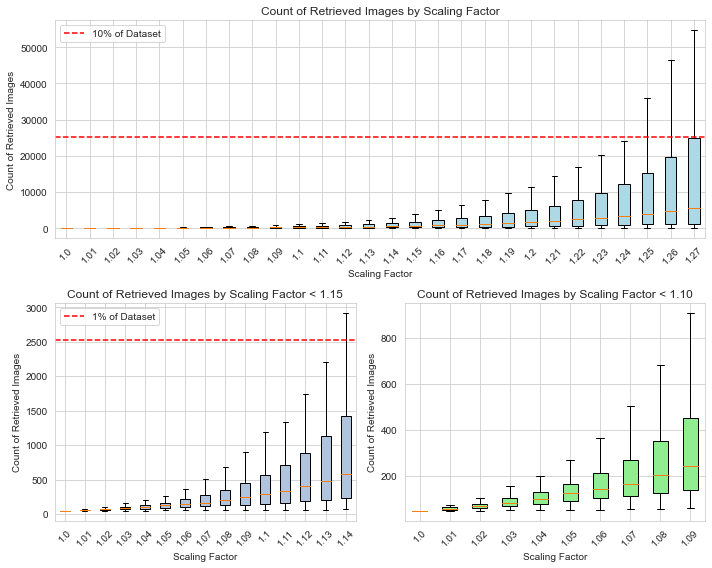

In [85]:
# Set up a 2x2 grid layout, but customize with GridSpec
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])  # First row taller

# First plot: All scaling factors (Boxplot) spanning two columns
ax1 = fig.add_subplot(gs[0, :])  # Span first row across two columns
ax1.boxplot(total_counts, labels=scaling_factors, patch_artist=True, 
            boxprops=dict(facecolor='lightblue', color='black'), showfliers=False)
ax1.axhline(y=ten_percent_value, color='r', linestyle='--', label='10% of Dataset')
ax1.set_xlabel('Scaling Factor')
ax1.set_ylabel('Count of Retrieved Images')
ax1.set_title('Count of Retrieved Images by Scaling Factor')
ax1.tick_params(axis='x', rotation=45, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
ax1.legend()
ax1.grid(True)

# Second plot: Boxplot for Scaling Factor < 1.15
ax2 = fig.add_subplot(gs[1, 0])  # Second row, first column
ax2.boxplot(total_counts_filtered_1_15.T, labels=scaling_factors_filtered_1_15, patch_artist=True,
            boxprops=dict(facecolor='lightsteelblue', color='black'), showfliers=False)
ax2.axhline(y=one_percent_value, color='r', linestyle='--', label='1% of Dataset')
ax2.set_xlabel('Scaling Factor')
ax2.set_ylabel('Count of Retrieved Images')
ax2.set_title('Count of Retrieved Images by Scaling Factor < 1.15')
ax2.tick_params(axis='x', rotation=45, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
ax2.legend()
ax2.grid(True)

# Third plot: Boxplot for Scaling Factor < 1.10
ax3 = fig.add_subplot(gs[1, 1])  # Second row, second column
ax3.boxplot(total_counts_filtered_1_10.T, labels=scaling_factors_filtered_1_10, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'), showfliers=False)
ax3.set_xlabel('Scaling Factor')
ax3.set_ylabel('Count of Retrieved Images')
ax3.set_title('Count of Retrieved Images by Scaling Factor < 1.10')
ax3.tick_params(axis='x', rotation=45, labelright=False, labelsize=10)  # Adjust label rotation, size, etc.
ax3.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [86]:
statistics = {
    "Scaling Factor": [],
    "25th Percentile": [],
    "Median": [],
    "75th Percentile": [],
    "Mean": []
}

for i, data in enumerate(total_counts):
    data = np.array(data)
    q1 = np.percentile(data, 25)
    median = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    mean = data.mean()
    
    statistics["Scaling Factor"].append(f"{scaling_factors[i]:.2f}")
    statistics["25th Percentile"].append(q1.astype(int))
    statistics["Median"].append(median.astype(int))
    statistics["75th Percentile"].append(q3.astype(int))
    statistics["Mean"].append(mean.astype(int))
    
# Create a DataFrame with the updated column names
df_stat = pd.DataFrame(statistics)
df_stat.iloc[::3].style.hide_index()

Scaling Factor,25th Percentile,Median,75th Percentile,Mean
1.00,50,50,50,50
1.03,68,84,106,92
1.06,103,145,214,191
1.09,139,243,452,441
1.12,187,411,891,1088
1.15,263,687,1809,2661
1.18,403,1198,3505,5918
1.21,634,2048,6251,11298
1.24,960,3398,12280,18509
1.27,1258,5577,24882,27237
